In [31]:
import os
from dotenv import load_dotenv

load_dotenv()

os.environ["GROOQ_API_KEY"] = os.getenv("GROQ_API_KEY")

from langchain_groq import ChatGroq
llm=ChatGroq(model_name="llama-3.1-8b-instant",temperature=0.7)

result=llm.invoke("Howdy")
result


AIMessage(content='Howdy back at ya. What can I help you with today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 37, 'total_tokens': 52, 'completion_time': 0.011972691, 'prompt_time': 0.006341235, 'queue_time': 0.218581746, 'total_time': 0.018313926}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_46fc01befd', 'finish_reason': 'stop', 'logprobs': None}, id='run--e857e676-ef56-492b-a258-83e97cc59f4d-0', usage_metadata={'input_tokens': 37, 'output_tokens': 15, 'total_tokens': 52})

In [32]:
from typing import TypedDict

class State(TypedDict):
    topic:str
    mood:str
    story:str
    improved_story:str
    final_story:str
    
    

In [33]:
# Build Nodes
def generate_story(state: State):
    story = llm.invoke(
        f"Write a clear, well-structured story about {state['topic']} "
        f"in a {state['mood']} mood. "
        f"If the topic refers to a historical, religious, or well-known figure, "
        f"base the story on their authentic background or tradition. "
        f"If it is fictional, create an original narrative. "
        f"Only return the story itself in polished prose — no lists, headings, or commentary."
    )
    return {"story": story.content}

def check_conflict(state: State):
    if "?" in state["story"] or "!" in state["story"]:
        return "Fail"
    else:
        return "Pass"

def improve_story(state: State):
    improved_story = llm.invoke(
        f"Improve the following story while keeping it aligned with the {state['mood']} mood "
        f"and the topic ({state['topic']}). "
        f"Enhance the descriptions and flow so it reads smoothly, "
        f"but do not add analysis, explanations, or character lists — just return the polished story.\n\n"
        f"{state['story']}"
    )
    return {"improved_story": improved_story.content}

def final_story(state: State):
    final_story = llm.invoke(
        f"Take this story and add a subtle twist or deeper reflection "
        f"that makes it more memorable and meaningful. "
        f"Return only the final narrative in clean, reader-friendly prose — "
        f"no headings, lists, or commentary.\n\n"
        f"{state['improved_story']}"
    )
    return {"final_story": final_story.content}


    

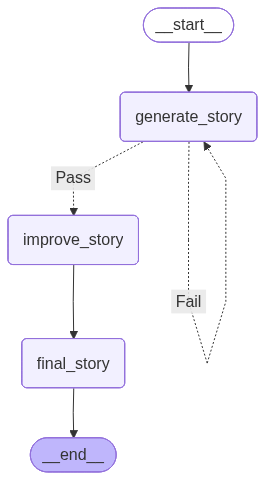

In [34]:

# Build State Graph
from IPython.display import display,Image
from langgraph.graph import StateGraph,START,END

graph=StateGraph(State)

graph.add_node("generate_story",generate_story)
graph.add_node("improve_story",improve_story)
graph.add_node("final_story",final_story)

graph.add_edge(START,"generate_story")
graph.add_conditional_edges("generate_story",check_conflict,{"Pass":"improve_story","Fail":"generate_story"})
graph.add_edge("improve_story","final_story")
graph.add_edge("final_story",END)

graph=graph.compile()

graph_image=graph.get_graph().draw_mermaid_png()
display(Image(graph_image))



In [35]:
## Run the graph 
result=graph.invoke({"topic":"The story of the Jesus","mood":"Victorious"})
result


{'topic': 'The story of the Jesus',
 'mood': 'Victorious',
 'story': 'In the midst of a triumphant fanfare, the sun burst forth, painting the sky with hues of glory, as if heaven itself was rejoicing in the arrival of the long-awaited Savior, Jesus Christ. The air was electric with anticipation, for the people of Jerusalem had heard whispers of a Messiah who would bring liberation from the shackles of oppression.\n\nWith each step, Jesus radiated an aura of confidence and joy, as if the very weight of His mission was a mantle He wore with ease. His eyes sparkled with an inner light, a divine fire that seemed to pierce the hearts of all who beheld Him. The crowd parted like a gentle breeze as He made His way through the bustling streets, His presence commanding attention without a word.\n\nAs He approached the Temple, the sound of psalms and hymns swelled in celebration, a chorus of praise that echoed through the sacred halls. The priests and scribes, caught up in the fervor, forgot the

In [36]:
result['final_story']

"In a radiant burst of glory, the sun ascended the sky, casting a kaleidoscope of colors, as if heaven itself was bursting forth in a joyous celebration of the long-awaited Savior's arrival. The air vibrated with anticipation, for the people of Jerusalem had heard whispers of a Messiah who would bring deliverance from the shackles of oppression and set their souls free. Yet, amidst the fervor and expectation, there was a subtle undertone of desperation, a hidden current of hope that was not just about redemption, but about the very survival of a people who had been worn down by centuries of suffering.\n\nWith each step, Jesus radiated an aura of unshakeable confidence and joy, as if the very weight of His mission was a mantle He wore with effortless ease. His eyes sparkled with an inner light, a divine fire that seemed to pierce the hearts of all who beheld Him, illuminating the path to redemption. The crowd parted like a gentle breeze as He made His way through the bustling streets, H

In [41]:
import subprocess

text = result['final_story']
if not isinstance(text, str):
    text = str(text)

# Speak immediately (built-in macOS TTS)
subprocess.run(["say", text])

CompletedProcess(args=['say', "In a radiant burst of glory, the sun ascended the sky, casting a kaleidoscope of colors, as if heaven itself was bursting forth in a joyous celebration of the long-awaited Savior's arrival. The air vibrated with anticipation, for the people of Jerusalem had heard whispers of a Messiah who would bring deliverance from the shackles of oppression and set their souls free. Yet, amidst the fervor and expectation, there was a subtle undertone of desperation, a hidden current of hope that was not just about redemption, but about the very survival of a people who had been worn down by centuries of suffering.\n\nWith each step, Jesus radiated an aura of unshakeable confidence and joy, as if the very weight of His mission was a mantle He wore with effortless ease. His eyes sparkled with an inner light, a divine fire that seemed to pierce the hearts of all who beheld Him, illuminating the path to redemption. The crowd parted like a gentle breeze as He made His way t